In [117]:
%pip install -U langgraph langchain-google-genai geopy requests python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [1]:

# Imports
from langgraph.prebuilt import create_react_agent
from langchain_google_genai import ChatGoogleGenerativeAI

/Users/lablnet/miniconda3/envs/stat/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import the classes from the rag.py file
from rag import OllamaEmbeddingGenerator, SimpleVectorSearch

In [3]:
# Import the tools from the tools.py file
from tools import get_weather, get_crypto_price, search_in_knowledge_base

📂 Embeddings loaded from hec_outline_embeddings.json
✅ Vector search initialized with 381 documents
🔍 Vector search initialized!


In [4]:
# Import the prompt from the prompt.py file
from prompt import system_prompt

In [5]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

In [6]:
api_key = os.getenv("GEMINI_API_KEY")

In [7]:
def create_llm(model: str = "gemini-2.5-flash", temperature: float = 1.0, max_retries: int = 2):
    """
    Create a LLM class
    
    Args:
        model: The model to use
        temperature: The temperature to use
        max_retries: The maximum number of retries
    
    Returns:
        A LLM class
    """
    # Create a LLM class
    return ChatGoogleGenerativeAI(
        model= model,
        temperature=temperature,
        max_retries=max_retries,
        google_api_key=api_key,
    )

In [8]:
# Create tools array/list.
all_tools = [
    get_weather,
    get_crypto_price,
    search_in_knowledge_base,
]

# Create the multi-tool agent
agent = create_react_agent(
    model=create_llm(),
    tools=all_tools,
    prompt=system_prompt
)

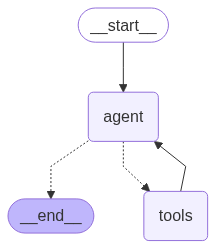

In [9]:
from IPython.display import Image

# Compile the state graph
graph = agent
Image(graph.get_graph().draw_mermaid_png())

In [10]:
def stream_conversation(agent, user_message):
    """
    Stream the conversation with the agent
    
    Args:
        agent: The agent to use
        user_message: The message to send to the agent
        
    Returns:
        None
    """
    # Create a path list
    path = ["User", "Agent"]
    
    # Print the title of the conversation
    print("=" * 70)
    print("🎬 MULTI-TOOL AGENT - REAL CONVERSATION")
    print("=" * 70)
    
    # Print the user message
    print(f"\n👤 USER:")
    print(f"   {user_message}")
    
    # Invoke the agent
    result = agent.invoke({"messages": [("user", user_message)]})
    
    # Iterate over the messages
    for message in result["messages"]:
        # If the message is an AI message
        if message.__class__.__name__ == 'AIMessage':
            # If the message has tool calls
            if hasattr(message, 'tool_calls') and message.tool_calls:
                for tool_call in message.tool_calls:
                    # Get the tool name
                    tool_name = tool_call['name']
                    print(f"🔧 Calling tool: {tool_name} with {tool_call['args']}")
                    
                    # Add tool node to path
                    path.append(tool_name)
                    path.append("Agent")
            elif message.content:
                # Print the AI message
                print(f"\n🤖 AI: {message.content}")
                # Add the user node to the path
                path.append("User")
        elif message.__class__.__name__ == 'ToolMessage':
            # Print the tool response
            print(f"🔧 TOOL RESPONSE: {message.content}")
    
    print("=" * 70)
    print("✅ CONVERSATION COMPLETE")
    print("=" * 70)

In [11]:
stream_conversation(agent, "What's the weather in Islamabad?")

🎬 MULTI-TOOL AGENT - REAL CONVERSATION

👤 USER:
   What's the weather in Islamabad?
🔧 Calling tool: get_weather with {'location': 'Islamabad'}
🔧 TOOL RESPONSE: {"time": "2025-09-17T02:45", "interval": 900, "temperature": 25.7, "windspeed": 3.3, "winddirection": 131, "is_day": 1, "weathercode": 1}

🤖 AI: The current weather in Islamabad is 25.7°C. It's a clear day with a wind speed of 3.3 km/h coming from the Southeast.
✅ CONVERSATION COMPLETE


In [30]:
stream_conversation(agent, "What's the price of Etherium?")

🎬 MULTI-TOOL AGENT - REAL CONVERSATION

👤 USER:
   What's the price of Etherium?
🔧 Calling tool: get_crypto_price with {'symbol': 'ethereum'}
🔧 TOOL RESPONSE: {"cryptocurrency": "Ethereum", "price_usd": 4511.05, "timestamp": "current"}

🤖 AI: The current price of Ethereum is $4511.05 USD.
✅ CONVERSATION COMPLETE


In [31]:
stream_conversation(agent, "What is the pre-requisite for MSCS?")

🎬 MULTI-TOOL AGENT - REAL CONVERSATION

👤 USER:
   What is the pre-requisite for MSCS?
🔍 Searching for: MSCS prerequisites admission requirements🔍 Searching for: Master Computer Science eligibility criteria Pakistan universities

🔍 Searching for: MS CS program entry requirements
🔍 Query embedding: [0.05043724551796913, -0.6360581517219543, 0.15903174877166748, -0.12056334316730499, 0.3594791293144226, 0.8401721715927124, -0.6616624593734741, 0.26618146896362305, -0.6132994294166565, 1.0250517129898071, -0.40061795711517334, 0.5099074840545654, 0.15249496698379517, -0.813286304473877, -0.1596142202615738, 0.6560714244842529, -0.6764212250709534, -0.45155176520347595, -1.104750633239746, -0.25847047567367554, 0.34913599491119385, 0.5102746486663818, -1.249768614768982, -0.248189777135849, -1.1995258331298828, -0.003332611173391342, 0.3059181869029999, 0.12561926245689392, 1.4295181035995483, 0.8705929517745972, -0.39483916759490967, 0.4744578003883362, 0.15608809888362885, -0.91908723115

In [13]:
stream_conversation(agent, "What subject do I need to study before taking studying subject Advance Operating System?")

🎬 MULTI-TOOL AGENT - REAL CONVERSATION

👤 USER:
   What subject do I need to study before taking studying subject Advance Operating System?
🔍 Searching for: Advance Operating System prerequisites
🔍 Searching for: Operating System course outline prerequisites
🔍 Searching for: Advanced Operating Systems required courses
🔍 Query embedding: [0.5428643226623535, -0.3007284104824066, 1.1473884582519531, -0.5970100164413452, -0.8744033575057983, -0.14525511860847473, -0.2993541955947876, -0.7586401104927063, -0.04350326210260391, 1.3540469408035278, 0.460298091173172, 0.328296959400177, 0.9176377058029175, -0.4238518476486206, 0.6456448435783386, 1.0597072839736938, -0.8379787802696228, -0.573421835899353, -1.120226502418518, -0.5057811737060547, 0.29094764590263367, -0.7076661586761475, -0.256592720746994, -0.20739370584487915, -0.9822471141815186, -0.15438513457775116, -0.1304701864719391, 1.2985743284225464, 1.1949026584625244, 0.7956855893135071, 0.23508694767951965, 0.6961974501609802, -

In [14]:
stream_conversation(agent, "What I will be study in course Operating System and what Is course outline?")

🎬 MULTI-TOOL AGENT - REAL CONVERSATION

👤 USER:
   What I will be study in course Operating System and what Is course outline?
🔍 Searching for: Operating System course outline Pakistan universities
🔍 Searching for: What is studied in Operating System course
🔍 Searching for: Operating System syllabus topics
🔍 Query embedding: [0.2597314715385437, -0.2857753336429596, 0.6762478947639465, -0.29978257417678833, -0.6684661507606506, -0.1378040909767151, -0.4758516550064087, 0.18503643572330475, -0.41418853402137756, 0.8644214868545532, 0.9383619427680969, 0.036129094660282135, 0.862528920173645, -0.3508027195930481, 0.051673680543899536, -0.11066360771656036, -0.12515312433242798, -0.533886730670929, -0.4349692463874817, -0.5987005233764648, 0.37560153007507324, 0.24399420619010925, -0.4434742033481598, -0.4649293124675751, -0.5473235249519348, -0.2879639267921448, -0.32256558537483215, 0.5792809128761292, 0.8465703129768372, 0.7094181776046753, -0.2682950794696808, 0.39968281984329224, 0.5